# Determining how many principal components to retain

If you have not already, then check out the example on Principal Components Analysis.

This notebook addresses techniques for identifying the number of 'real' principal componenents that represent a data set.  Owing to (multi)-collinearity among the features this can be less than the number of PCs it is possible to compute (i.e. whatever is the fewer of the number of training features or the number of observations).

Five methods for this are implemented in python_shape_stats:
1. Heuristic methods
    1. Specified variance
    2. Scree test
3. Null model-based methods
    1. Broken stick
    1. Parallel analysis

First up we can simulate some data, which has a known number of true PCs.

In [8]:
from python_shape_stats import helpers
from python_shape_stats.statistical_shape_models import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import copy

In [9]:
##### simulate data with 5 real PCS plus noise
# These are the simulation parameters from the third experiment of Minka (2000) https://vismod.media.mit.edu/tech-reports/TR-514.pdf
TRUE_EIGENVALUES = [10,8,6,4,2]# how many real PCs will there be in
NOISE_VARIANCE = 1/4
NUM_FEATURES =100 # must be greater than len(TRUE_EIGENVALUES)
NUM_OBS  = 60 # how many observations

# make a random number generator to be used throughout
RNG = np.random.default_rng(1546)

#### Generate covariance matrix
# sample a random orthonormal basis (eigenvectors of the covariance matrix)
sampler = ortho_group(dim=NUM_FEATURES,seed=RNG)
pop_eig_vec = sampler.rvs(1)

# put together the true and noise eigenvalues
pop_eig_val = np.concatenate([TRUE_EIGENVALUES,np.tile(NOISE_VARIANCE,NUM_FEATURES-len(TRUE_EIGENVALUES))])

# put together the covariance matrix
pop_cov =pop_eig_vec @ np.diag(pop_eig_val) @ pop_eig_vec.T

# sample data
sample_data = RNG.multivariate_normal(mean=np.zeros(NUM_FEATURES),cov=pop_cov,size=NUM_OBS)

## Heuristic methods
### Specified variance

Each PC explains a certain amount of variance in the data. The amount of variance explained across all the PCs is sometimes called its 'spectrum'. The cumulative percentage of the variance explained by PCs 1:i is said to be the cumulative percentage of variance explained at PC i.

One approach is to keep only those pcs that explain up to a specified percentage of the total variation. In my opinion this makes sense if you have some prior knowledge about the ratio of signal to noise in the data. For example in the analysis of variation in 3D anatomy from 3D imaging methods, typically there is very little noise, relative to the amount of biological signal. Therefore common cut-offs used are often relatively high 96%, 98% or 99%. In this context cut-offs of between 90-97% approximate the results of parallel analysis (see below) on a large dataset (of human [faces](https://doi.org/10.1038%2Fs41588-018-0057-4) - see suppl Fig. 2)

You can do this using the 'trim_perc_var' method of the PCA class. Below demonstrates this. In this case we trim the model to include only those explaining up to 96% of variation, leaving us with 40 PCs.



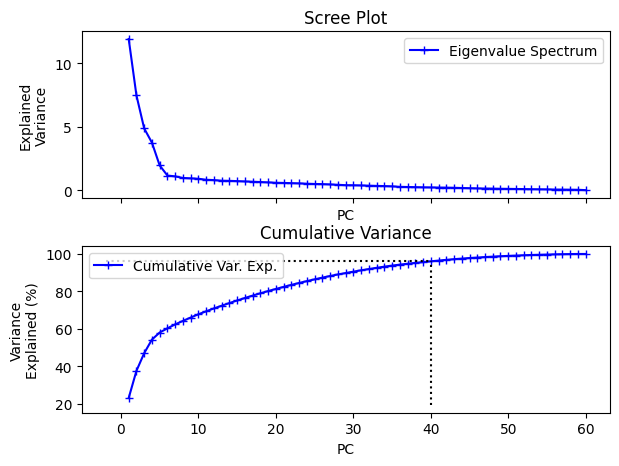

In [10]:
# fit pca to sample data
pca_model = PCA()
pca_model.fit_transform(sample_data)

# plot the eigenvalue spectrum and the cumulative variance explained
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
fig.tight_layout(pad = 2.5)
pca_model.scree_plot(ax1)
pca_model.cumulative_variance_plot(ax=ax2)

# keep those PCs that explain up to 96% of the total variance
pca_model.trim_perc_var(96.)

# how many PCs are left
no_pcs = pca_model.n_dim
# how much variance do they explain (it may be slightly more than 96%)
var_exp = pca_model.cumulative_perc_var[-1]

ax2.hlines(var_exp,xmin=ax2.get_xlim()[0],xmax=no_pcs,ls=':',colors='k')
ax2.vlines(no_pcs,ymin=ax2.get_ylim()[0],ymax=var_exp,ls=':',colors='k')


## Scree test
We have already seen a scree plot above. A scree plot simply plots the variance explained (eigenvalue) per PC. The scree test involves visually inspecting such a plot and identifying the point at which the eigenvalues start to level off (this is sometimes called the 'elbow' of the plot). The **assumption being that when PCs explain equal amounts of variation the 'directions' of the PCs are interchangeable and presumably random.**

You can quickly make a scree plot using the 'scree_plot' method of the PCA class. With the number of PCs determined you can trim the model with the trim_no_pcs method of the PCA class.

Axes(0.125,0.11;0.775x0.77)
6 PCs retained


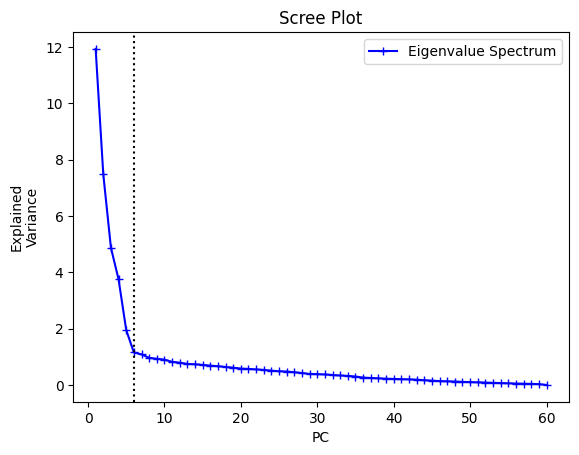

In [11]:
# fit pca to sample data
pca_model = PCA()
pca_model.fit_transform(sample_data)
ax,_=pca_model.scree_plot()
print(ax)
# where I see the approximate elbow
ELBOW_POINT = 6
ax.axvline(ELBOW_POINT,label='~Elbow',color='k',ls = ':')
pca_model.trim_no_pcs(ELBOW_POINT)
print(str(pca_model.n_dim)+' PCs retained')

Of course this approach is somewhat (possibly a lot) subjective. A further issue is that completely unstructured data will not actually yield equal eigenvalues so looking for the point at which eigenvalues approach uniformity may not be the best approach.

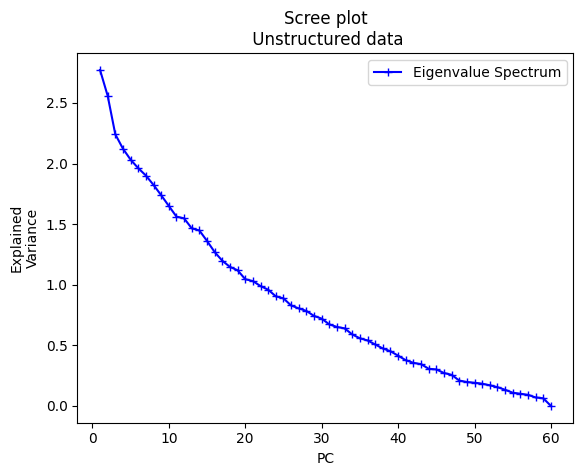

In [12]:
# shuffle rows and columns independently then do pca
shuff_data = helpers.randomize_matrix(sample_data,seed=RNG)
shuff_mod = PCA()
shuff_mod.fit(shuff_data)

# plot the eigenvalues
ax,_ = shuff_mod.scree_plot()
ax.set_title('Scree plot\n Unstructured data')
plt.show()

## Null model-based methods
Although the two foregoing methods are somewhat different, they conceptualise 'real' principal components in the same way: i.e. those PCs those whose eigenvalues differ from what would be expected by random chance (if there was no structure to the data). They both establish what are expected eigenvalue spectra if there was no real structure in the data (I will call this the 'null' spectra). Detecting real principal componenents then amounts to detecting where the observed spectrum deviates enough from the null. The approaches differ in how they determine the null spectra.

### Broken stick
 Think of the total variance to be explained as a stick. If you break the stick into N pieces randomly, with a break at any location on the stick being equally likely, some segments will still be longer than others (some components will explain more variance than others). If you repeat this multiple times you will end up with distributions of the expected length of the longest to the shortest stick.

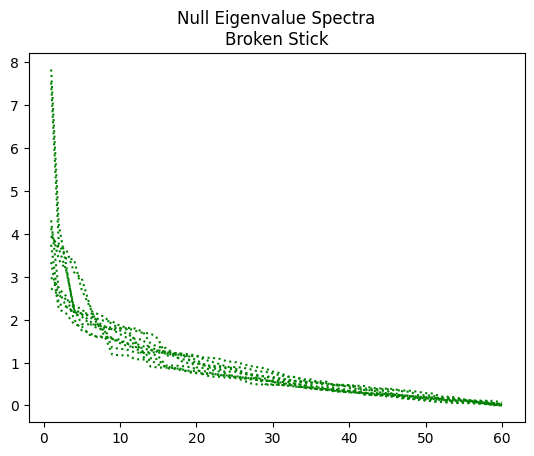

In [13]:
# fit pca to sample data
pca_model = PCA()
pca_model.fit_transform(sample_data)

n = pca_model.n_dim# how many pieces is the variation being divided into - equal to the initial number of components
j=np.sum(pca_model.eig_val)# how much variance is being divided up

N_REPS=10
ax = plt.subplot()
for it in range(N_REPS): # estimate N_REPS null spectra and plot
    # randomly select points to break up the variation (the stick)
    bp = RNG.uniform(0, j, n - 1)
    # add the start and end of the stick
    bp = np.concatenate([np.atleast_1d(0),bp,np.atleast_1d(j)])
    # sort ascending
    bp = np.sort(bp)
    # compute length between the i-1th breakpoint to the ith
    segment_lengths = bp[1:]-bp[0:-1]
    # sort descending
    segment_lengths = np.sort(segment_lengths)
    segment_lengths = segment_lengths[::-1]
    ax.plot(np.linspace(1,n,n),segment_lengths,c='g',ls=':')

ax.set_title('Null Eigenvalue Spectra\nBroken Stick')
plt.show()

### Parallel analysis
Parallel analysis establishes the null spectra slightly differently. Instead it generates multiple datasets of the same size and total variance as the dataset being investigated, but within which there is known to be no structure, and computes the eigenvalue spectra of these datasets.

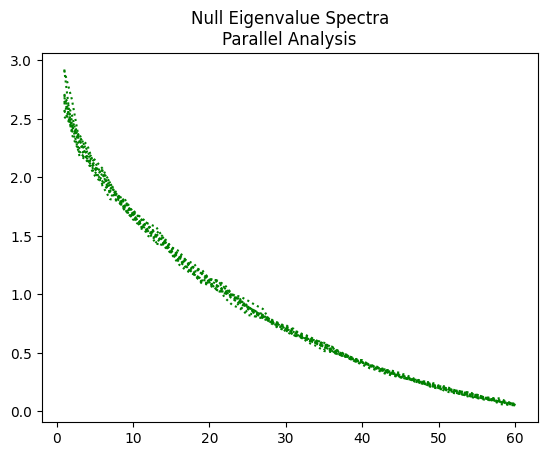

In [14]:
N_REPS=10
ax = plt.subplot()
for it in range(N_REPS): # estimate N_REPS null spectra and plot
    #shuffle the rows and columns
    shuff_data = helpers.randomize_matrix(sample_data,seed=RNG)
    shuff_pc = PCA()
    shuff_pc.fit(shuff_data,center=False)
    ax.plot(np.linspace(1,n,n),shuff_pc.eig_val,c='g',ls=':')
ax.set_title('Null Eigenvalue Spectra\nParallel Analysis')
plt.show()

### Comparison
In practice we do many repetitions to build up these null distributions. These distributions can then be compared to the observed eigenvalue spectrum graphically and by setting a criteria for PC selection. For example we can select up to the last pc whose eigenvalue is above the 50th percentile (median) of the distribution of null spectra.

Output()

Parallel analysis detected 4PCs.
Broken stick detected 4PCs.


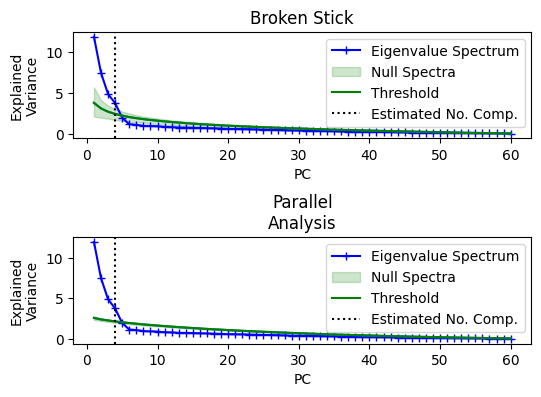

In [7]:
CI_LEVEL = 95. # plot as filled regions between the 0th and the 95th percentile
THRESHOLD_LEVEL = 50. # accept up to the last PC whose eigenvalue is greater than the 50th percentile of the null spectra
N_REPS = 1000 # how many null spectra to use to build the distribution...in practice set this higher but to quickly illustrate I set this low
# fit pca to sample data
pca_model = PCA()
pca_model.fit_transform(sample_data)

fig,(ax1,ax2) = plt.subplots(2,1,sharey=True)
fig.tight_layout(pad=5.0)
# do broken stick selection
_,n_comps_bs = pca_model.broken_stick_plot(ci_level=CI_LEVEL,threshold_level=THRESHOLD_LEVEL,n_reps=N_REPS,ax=ax1)

# do parallel analysis selection
_,n_comps_pa = pca_model.parallel_analysis_plot(ci_level=CI_LEVEL,threshold_level=THRESHOLD_LEVEL,n_reps=N_REPS,ax=ax2)

print('Parallel analysis detected '+str(n_comps_pa)+ 'PCs.')
print('Broken stick detected '+str(n_comps_bs)+ 'PCs.')
plt.show()